# set-up

In [37]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random
import re
#os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
#from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from plotting_functions import colour_dict

In [3]:
random_seed=random.seed(211)

In [4]:
save_fig=True

In [4]:
#whether to rerun the significance analysis for network colocalization
rerun_colocalization=False

In [54]:
hgnc=pd.read_csv('hgnc_complete_set.txt',sep='\t',low_memory=False)
hgnc=hgnc[['symbol','entrez_id']].dropna()
hgnc['entrez_id']=hgnc['entrez_id'].astype(int).astype(str)


In [53]:
netdir='tissue_networks/intermediate/'

tissue_list=['basal_ganglion', 'brain', 'caudate_nucleus', 'caudate_putamen', 'central_nervous_system', 'cerebellar_cortex', 'cerebellum', 'cerebral_cortex', 'corpus_callosum', 'corpus_striatum', 'dentate_gyrus', 'diencephalon', 'forebrain', 'frontal_lobe', 'glia', 'hippocampus', 'hypophysis', 'hypothalamus', 'locus_ceruleus', 'medulla_oblongata', 'midbrain', 'nervous_system', 'neuron', 'nucleus_accumbens', 'occipital_lobe', 'occipital_pole', 'pons', 'peripheral_nervous_system', 'spinal_cord', 'substantia_nigra', 'subthalamic_nucleus', 'telencephalon', 'temporal_lobe', 'thalamus', 'bronchial_epithelial_cell', 'bronchus', 'lung', 'trachea', 'global']

In [45]:
def return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name):
    #labels
	if not (trait_h==None):
	    if cut_h==None:
	        label_h=trait_h
	    else:
	        label_h=trait_h+'_'+cut_h
	    seed_h=seed_dict[label_h]
	    NPS_h=NPS_dict[label_h+'_'+interactome_name]
	else:
		trait_h=None
		label_h=None
		cut_h=None
		seed_h=None
		NPS_h=None

	if not (trait_r==None):
	    if cut_r==None:
	        label_r=trait_r
	    else:
	        label_r=trait_r+'_'+cut_r
	    seed_r=seed_dict[label_r]
	    NPS_r=NPS_dict[label_r+'_'+interactome_name]

	else:
		trait_r=None
		label_r=None
		cut_r=None
		seed_r=None
		NPS_r=None
    #seed genes
    #NPS scores
	if ((trait_h!=None) and (trait_r!=None)):
	    NPS = NPS_h.join(NPS_r, lsuffix="h", rsuffix="r")
	    NPS = NPS.assign(zhr=NPS.zh * NPS.zr)
	else:
	    NPS=None
	return label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS

In [13]:
def remove_subscript (string,type): 
    for s in ['_FDR','_top500','_bonf']:
        if s in string:
            if type=='trait':
                string = string.replace(s, '')
            if type=='cutoff':
                string=s[1:len(string)]
    if ((type=='cutoff') & (string=='')):
        string='other'
    return string

In [55]:
for tissue in tissue_list:
    interactome_name=f'hb_tissue_{tissue}_top'
    print(interactome_name)
    #import node list
    with open(f'{netdir}node_list_{tissue}_top.txt', 'r') as file:
        lines = file.readlines()
    # Remove newline characters from each line
    all_nodes=[line.strip() for line in lines]
    #import seed genes    
    seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,hgnc[hgnc.entrez_id.isin(all_nodes)]['symbol'])
    ctrl_dict={}
    ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
    for t in ctrl_traits:
        ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
    for t in ctrl_traits:
        seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
        seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
        seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

    
    seed_dict={k: set(hgnc[hgnc.symbol.isin(v)]['entrez_id']) for k, v in seed_dict.items()}
    #import NPS
    NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)

    #choose which cutoffs to run- only using ones used for whole network here
    cutoff_comb=3
    cutoff_single=1.5
    zlist=[cutoff_comb]
    z12list=[cutoff_single]

    ctrl_traits=['ext_bonf','ext_top500','ext_FDR','addict-rf_FDR','addict-rf_bonf','addict-rf_top500']

    #modify for correct genesets
    trait_r='loco_final_cf'
    trait_h=None
    cut_h=None
    for cut_r in ['FDR','bonf','top500']:
        _,label_r,_,seed_r,_,NPS_r,_=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)
        print(trait_r)
        for label_h in ctrl_traits:
                print(label_h)
                coloc_filename=f'colocalization_scores/colocScore_{label_r}_{label_h}_{interactome_name}.tsv'
                if not (os.path.exists(coloc_filename)):
                    print('running analysis')
                    seed_h=seed_dict[label_h]
                    NPS_h=NPS_dict[label_h+'_'+interactome_name]
                    netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(NPS_r,NPS_h,
                                                                                                 zthresh_list = zlist,
                                                                                                 z12thresh_list=z12list,
                                                                                                 verbose=False)
                    #netcoloc_enrichment_df=netcoloc_enrichment_df[netcoloc_enrichment_df['z_comb']>=netcoloc_enrichment_df['NPS_single']]
                    #print(netcoloc_enrichment_df)
                    netcoloc_enrichment_df['rat_dataset']=label_r
                    netcoloc_enrichment_df['human_dataset']=label_h
                    if save_fig:
                        netcoloc_enrichment_df.to_csv('colocalization_scores/colocScore_'+label_r+'_'+label_h+'_'+interactome_name+'.tsv',sep='\t',index=False)
                else:
                    print('file already exists')

hb_tissue_basal_ganglion_top
loco_final_cf
ext_bonf
running analysis
ext_top500
running analysis
ext_FDR
running analysis
addict-rf_FDR
running analysis
addict-rf_bonf
running analysis
addict-rf_top500
running analysis
loco_final_cf
ext_bonf
running analysis
ext_top500
running analysis
ext_FDR
running analysis
addict-rf_FDR
running analysis
addict-rf_bonf
running analysis
addict-rf_top500
running analysis
loco_final_cf
ext_bonf
running analysis
ext_top500
running analysis
ext_FDR
running analysis
addict-rf_FDR
running analysis
addict-rf_bonf
running analysis
addict-rf_top500
running analysis
hb_tissue_brain_top
loco_final_cf
ext_bonf
running analysis
ext_top500
running analysis
ext_FDR
running analysis
addict-rf_FDR
running analysis
addict-rf_bonf
running analysis
addict-rf_top500
running analysis
loco_final_cf
ext_bonf
running analysis
ext_top500
running analysis
ext_FDR
running analysis
addict-rf_FDR
running analysis
addict-rf_bonf
running analysis
addict-rf_top500
running analysis
l

# plot colocalization

In [5]:
files=os.listdir('colocalization_scores')
files.remove('.ipynb_checkpoints')

In [6]:
files=[x for x in files if 'tissue' in x]
files=[x for x in files if ~('munged' in x)]
files=[x for x in files if ('ext' in x) or ('addict' in x)]

In [64]:
tbl=pd.DataFrame()
for f in files:
    print(f)
    t=pd.read_csv(f'colocalization_scores/{f}',sep='\t')
    t=t[(t.z_comb==cut_comb) & (t.z_12==cut_single)]
    t['tissue']=re.search('hb_tissue_(.*)_top.tsv', f)[1]
    tbl=pd.concat([tbl,t],axis=0,ignore_index=True)
    print(len(tbl))

colocScore_loco_final_cf_top500_ext_top500_hb_tissue_trachea_top.tsv
1
colocScore_loco_final_cf_top500_ext_FDR_hb_tissue_forebrain_top.tsv
2
colocScore_loco_final_cf_top500_addict-rf_bonf_hb_tissue_bronchial_epithelial_cell_top.tsv
3
colocScore_loco_final_cf_bonf_ext_bonf_hb_tissue_peripheral_nervous_system_top.tsv
4
colocScore_loco_final_cf_FDR_ext_bonf_hb_tissue_corpus_callosum_top.tsv
5
colocScore_loco_final_cf_FDR_ext_FDR_hb_tissue_corpus_callosum_top.tsv
6
colocScore_loco_final_cf_top500_ext_rtb_bonf_hb_tissue_global_top.tsv
7
colocScore_loco_final_cf_FDR_ext_top500_hb_tissue_basal_ganglion_top.tsv
8
colocScore_loco_final_cf_bonf_ext_top500_hb_tissue_cerebellum_top.tsv
9
colocScore_loco_final_cf_top500_addict-rf_FDR_hb_tissue_nucleus_accumbens_top.tsv
10
colocScore_loco_final_cf_top500_addict-rf_FDR_hb_tissue_hippocampus_top.tsv
11
colocScore_loco_final_cf_top500_addict-rf_top500_hb_tissue_medulla_oblongata_top.tsv
12
colocScore_loco_final_cf_bonf_ext_FDR_hb_tissue_substantia_nigr

In [65]:
tbl['rat_trait']=tbl['rat_dataset'].apply(remove_subscript,type='trait')
tbl['rat_cutoff']=tbl['rat_dataset'].apply(remove_subscript,type='cutoff')
tbl['human_trait']=tbl['human_dataset'].apply(remove_subscript,type='trait')
tbl['human_cutoff']=tbl['human_dataset'].apply(remove_subscript,type='cutoff')

tbl=tbl[(~tbl['rat_dataset'].str.contains('fus'))& (~tbl['human_dataset'].str.contains('fus'))]
tbl=tbl[(~tbl['rat_dataset'].str.contains('rat'))& (~tbl['human_dataset'].str.contains('rat'))]
tbl=tbl[(~tbl['human_dataset'].str.contains('loco'))]
tbl=tbl.reset_index().drop('index',axis=1)
tbl=tbl[(~tbl['human_dataset'].str.contains('ext_db'))]
tbl=tbl[(~tbl['human_dataset'].str.contains('ext_rtb'))]
tbl=tbl[(~tbl['human_dataset'].str.contains('ext_st22'))]


In [69]:
tbl_sub=tbl[tbl.rat_dataset=='loco_final_cf_FDR'].reset_index().drop('index',axis=1)

In [73]:
t=tbl_sub.pivot(index='tissue', columns='human_dataset', values='obs_exp')
distance=t.applymap(lambda x: (x - 1))
annot_data=tbl_sub.pivot(index='tissue', columns='human_dataset', values='empirical_p')
annot=annot_data.applymap(lambda p: '*' if p < 0.05/len(tbl_sub) else '')

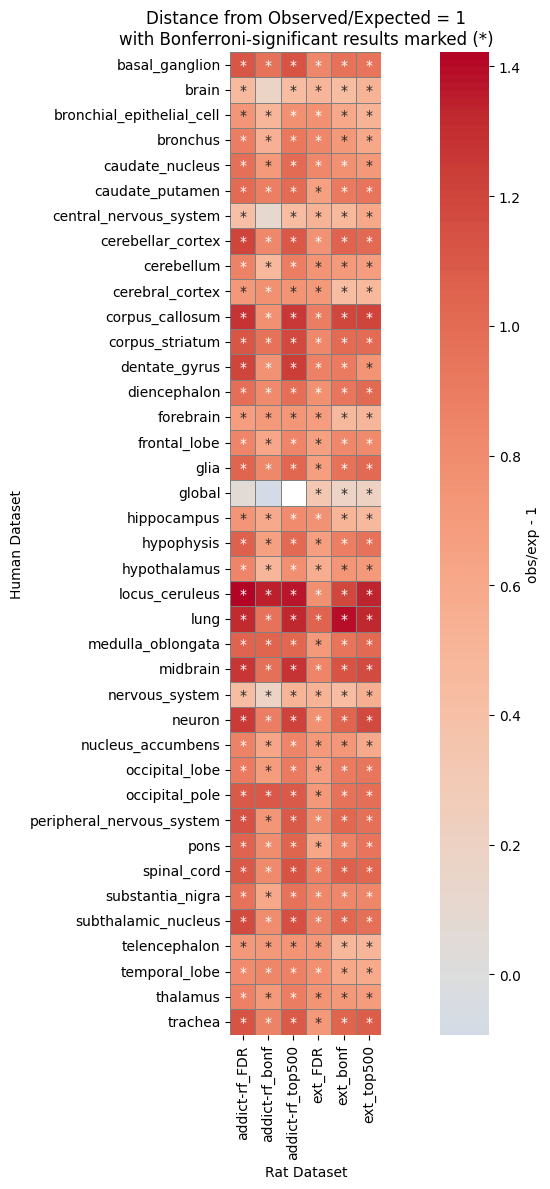

In [74]:
plt.figure(figsize=(12,12))
sns.heatmap(distance, annot=annot, fmt='', cmap='coolwarm', center=0,
            cbar_kws={'label': 'obs/exp - 1'}, linewidths=0.5, linecolor='gray',square=True)

plt.title('Distance from Observed/Expected = 1\nwith Bonferroni-significant results marked (*)')
plt.ylabel('Human Dataset')
plt.xlabel('Rat Dataset')
plt.tight_layout()
plt.show()

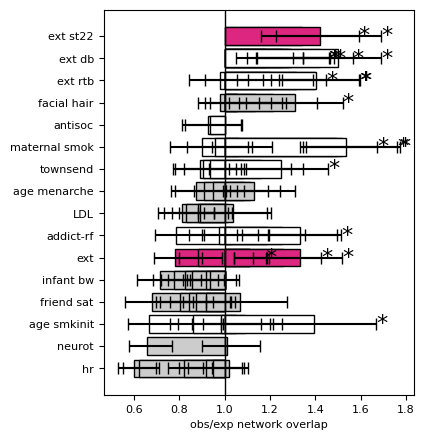

In [156]:
plt.figure(figsize=(4,5))

# Create horizontal bars
bars = plt.barh(y=tbl_sub.human_trait.map(lambda x: x.replace('_',' ')),
                left=1, width=tbl_sub.obs_exp - 1, capsize=4, edgecolor="black",
                xerr=[tbl_sub.lower_error, tbl_sub.upper_error],
                color=tbl_sub.colour)

# Set labels and title
plt.yticks(rotation=0)
plt.xlabel('obs/exp network overlap')
#plt.title(subset)
plt.axvline(x=1, color='black', linestyle='solid', linewidth=1)

# Find the maximum width to set a limit for star placement
max_width = max(tbl_sub.obs_exp - 1 + tbl_sub.upper_error)

# Add significance stars
for i, (bar, sig, upper_err) in enumerate(zip(bars, tbl_sub.sig_overlap, tbl_sub.upper_error)):
    if sig:  # if sig_overlap is True
        # Get the bar's width and position to place the star
        star_x_position = bar.get_width() + 1 + upper_err  # Add a small margin above the error bar
        plt.text(star_x_position, bar.get_y() + bar.get_height() / 2, '*',
                 ha='left', va='center', fontsize=16, color='black')
if save_fig:
    plt.savefig('../figures/barplot_network_overlap_vertical.svg',bbox_inches='tight')